In [68]:
import numpy as np
import pandas as pd
import torch
from sklearn.datasets import fetch_openml
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchmetrics.functional as metrics
from sklearn.preprocessing import OneHotEncoder
import imageio
import matplotlib.pyplot as plt

In [69]:
mnist = fetch_openml('mnist_784', as_frame= True, parser='auto')

In [70]:
mnist.target[0]

'5'

In [71]:
target = mnist['target']
feature = mnist['data']

In [72]:
target.value_counts()

class
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: count, dtype: int64

In [73]:
# target object 타입이라서 형변환
target = target.astype('int')

In [74]:
target.shape, feature.shape

((70000,), (70000, 784))

In [75]:
# # 타겟 원핫인코딩
# target = OneHotEncoder().fit_transform(target.values.reshape(-1,1))
# target.shape

In [76]:
class DLDataset(Dataset):

    # 초기화 함수
    def __init__(self,x_data,y_data):
        super().__init__()
        # x, y data => ndarray
        x_data = x_data.values if isinstance(x_data, pd.DataFrame) else x_data
        y_data = y_data.values if isinstance(y_data, pd.DataFrame) else y_data

        # ndarray => tensor : 텐서화
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.LongTensor(y_data)

    # 데이터셋의 갯수 체크 함수
    def __len__(self):
        return self.target.shape[0]
        pass

    # 특정 인덱스 데이터 + 라벨 반환 콜백 함수 - 튜플로 반환
    def __getitem__(self,index):
        return self.feature[index],self.target[index]
        pass

In [77]:
dataset = DLDataset(feature,target)

In [78]:
len(dataset)

70000

In [79]:
# 학습용, 검증용, 테스트용 데이터셋 나누기
seed = torch.Generator().manual_seed(42)
trainDS, valDS, testDS = random_split(dataset, [0.7,0.1,0.2], generator=seed)  # subset 타입

In [80]:
batch = 128
trainDL = DataLoader(trainDS, batch_size=batch)
validDL = DataLoader(valDS, batch_size=batch)
testDL = DataLoader(testDS, batch_size=batch)
len(trainDL), len(validDL), len(testDL)

(383, 55, 110)

In [81]:
# 모델 클래스 정의
class CModel(nn.Module):

    # 모델 구조 설정
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.input_layer = nn.Linear(in_dim, 100)
        self.relu = nn.ReLU()  # 0보다 작거나 같으면 0 / 0보다 크면 1
        self.hidden_layer = nn.Linear(100, 50)
        self.output_layer = nn.Linear(50, out_dim)

    # 순방향 학습 진행 콜백 함수

    def forward(self, x):
        y = self.input_layer(x)
        y = self.relu(y)
        y = self.hidden_layer(y)
        y = self.relu(y)
        y = self.output_layer(y)
        return y

In [82]:
# 실행 디바이스 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# 모델 인스턴스
IN_DIM = dataset.feature.shape[1]
OUT_DIM = len(torch.unique(dataset.target))  # or len(np.unique(targetNP) or tragetDF.nunique()

model = CModel(IN_DIM, OUT_DIM).to(DEVICE)

# 손실함수
LOSS_FUNCTION =   nn.CrossEntropyLoss().to(DEVICE)

# 최적화 인스턴스
OPTIMIZER = optim.Adam(model.parameters(), lr = 1e-2)

# 스케쥴러
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, 'min', patience=3)

In [83]:
# 학습 진행함수
def training(dataLoader):
    # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 활성화
    model.train()

    # 배치크기만큼 학습진행 및 저장
    train_loss = 0
    train_acc = 0
    for cnt, (feature, target) in enumerate(dataLoader):
        feature, target = feature.to(DEVICE), target.to(DEVICE)
        # 학습
        pre_target = model(feature)

        # 손실계산
        loss = LOSS_FUNCTION(pre_target,target)
        train_loss += loss.item()

        # 정확도
        acc = metrics.accuracy(pre_target, target, task = 'multiclass', num_classes=len(torch.unique(dataset.target)))
        train_acc += acc.item()

        # W, b 업데이트
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()

    # 에포크 단위 학습 진행 메시지 출력
    print(f'[Train loss] ==> {train_loss/ len(dataLoader)}    [Train Accuracy] ==> {train_acc / len(dataLoader)}')

    return train_loss/ len(dataLoader), train_acc / len(dataLoader)

In [84]:
# train_loss, train_acc = training(trainDL)

In [85]:
# 검증 및 평가 진행 함수
def testing(dataLoader):
    # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 비활성화
    model.eval()

    with torch.no_grad():
        # 배치크기만큼 학습진행
        val_loss = 0
        val_acc = 0
        for cnt, (feature, target) in enumerate(dataLoader):
            feature, target = feature.to(DEVICE), target.to(DEVICE)
            # 학습
            pre_target = model(feature)

            # 손실계산
            loss = LOSS_FUNCTION(pre_target,target)
            val_loss += loss.item()

            # 정확도
            acc = metrics.accuracy(pre_target, target, task = 'multiclass', num_classes=len(torch.unique(dataset.target)))
            val_acc += acc.item()

    # 에포크 단위 학습 진행 메시지 출력
    print(f'[Valid loss] ==> {val_loss/ len(dataLoader)}    [Valid Accuracy] ==> {val_acc / len(dataLoader)}')

    return val_loss/ len(dataLoader), val_acc / len(dataLoader)

In [86]:
# testing(validDL)

In [87]:
EPOCHS = 30
min_loss = 100.0  # 초기 최소 손실 설정
cnt = 0
for eps in range(EPOCHS):
    print(f'[{eps+1}/{EPOCHS}]')
    # 학습
    train_loss, train_acc = training(trainDL)

    # 검증
    val_loss, val_acc = testing(validDL)

    # 최소 손실 업데이트
    if val_loss < min_loss:
        min_loss = val_loss
        cnt = 0
    else:
        cnt+=1

    # 조기 종료 기능 => 조건 : val_loss가 지정된 횟수 이상 개선이 안되면 학습 종료
    if SCHEDULER.num_bad_epochs >= SCHEDULER.patience or cnt >= 2:
        print(f"Early stopping at epoch {eps}")
        break

[1/30]
[Train loss] ==> 1.4053245040517564    [Train Accuracy] ==> 0.8156036603855402
[Valid loss] ==> 0.3282554962418296    [Valid Accuracy] ==> 0.9139462806961753
[2/30]
[Train loss] ==> 0.33475714943349827    [Train Accuracy] ==> 0.9084043608633097
[Valid loss] ==> 0.3090452083132484    [Valid Accuracy] ==> 0.9168646693229675
[3/30]
[Train loss] ==> 0.2901068845515774    [Train Accuracy] ==> 0.9213572002888971
[Valid loss] ==> 0.3247006053274328    [Valid Accuracy] ==> 0.9190728306770325
[4/30]
[Train loss] ==> 0.28722285736089587    [Train Accuracy] ==> 0.922637577778988
[Valid loss] ==> 0.286755675890229    [Valid Accuracy] ==> 0.9274535124952142
[5/30]
[Train loss] ==> 0.2852261342672393    [Train Accuracy] ==> 0.925915407138456
[Valid loss] ==> 0.31326144960793584    [Valid Accuracy] ==> 0.9219266533851623
[6/30]
[Train loss] ==> 0.2841751474702327    [Train Accuracy] ==> 0.9262119653019519
[Valid loss] ==> 0.3113020051609386    [Valid Accuracy] ==> 0.9215650829401884
Early stop

In [97]:
# 예측 함수
def predict(dataset,n):
    model.eval()

    correct = 0
    total = 0

    for idx in range(len(dataset)):
        img, ytrue = dataset[idx][0], dataset[idx][1]

        with torch.no_grad():
            ypre = model(img.unsqueeze(0))
            ypre = torch.argmax(ypre, dim=1).item()

            if ypre == ytrue:
                correct += 1

            total += 1
            if idx < n :
                plt.imshow(dataset[idx][0].numpy().reshape(28, 28), cmap='gray_r')
                plt.title(f'[{idx+1}] True {ytrue} / Predict {ypre}')
                plt.xticks([])
                plt.yticks([])
                plt.show()

    accuracy = correct / total
    print(f'Accuracy: {accuracy:.2f}')
    return accuracy

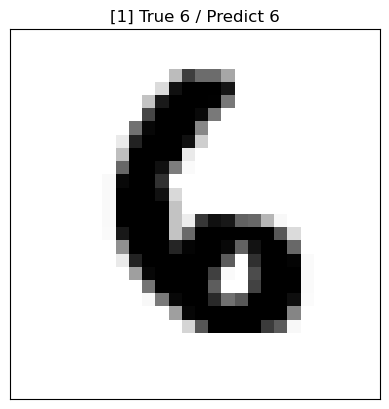

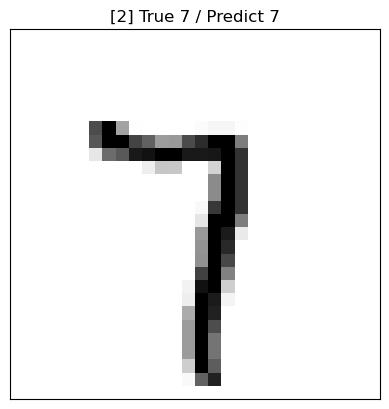

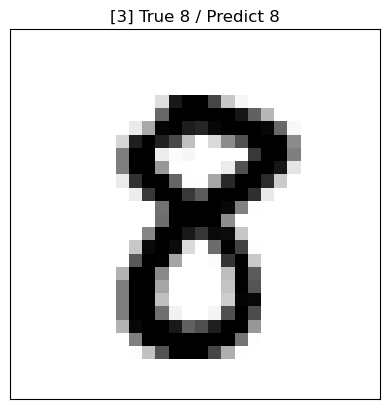

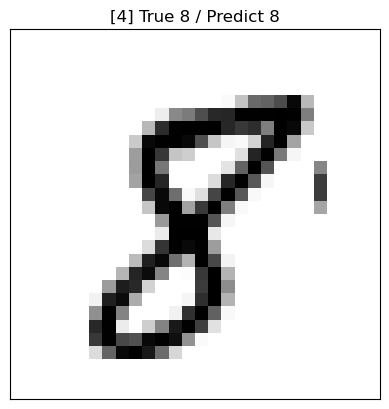

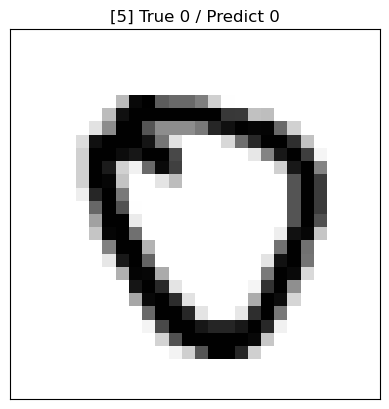

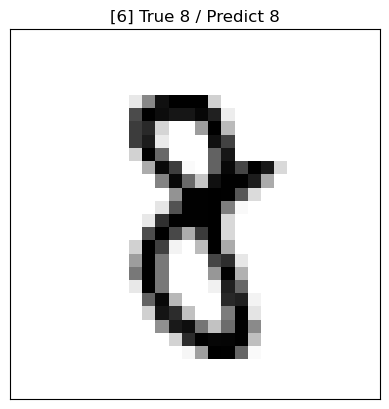

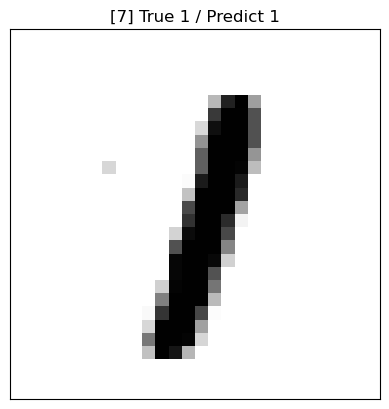

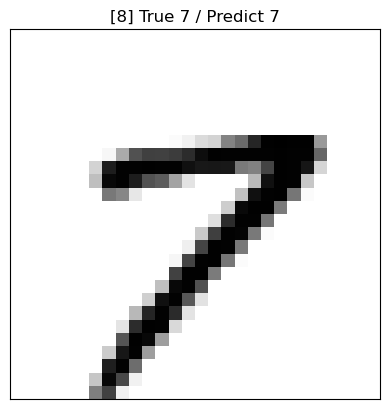

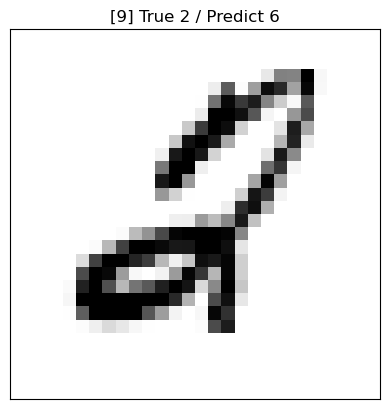

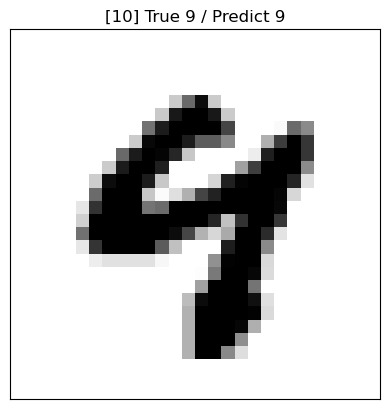

Accuracy: 0.92


In [98]:
test_acc = predict(testDS,10)